In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import percentileofscore

In [2]:

def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&mode=8&sort=0'

    last_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        last_index_run = get_arome_data(url_run).index[-1]

        if last_index_run > last_index:
            last_index = last_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_arome_run()




aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')


In [3]:

def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data

def get_wind_gust_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=13&sort=0'
    url_run = f'{url}&run={valid_run}'

    wind_gust_data = get_arome_data(url_run)

    return wind_gust_data

def get_pressure_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=1&sort=0'
    url_run = f'{url}&run={valid_run}'

    pressure_data = get_arome_data(url_run)

    return pressure_data

def get_mucape_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=0&sort=0'
    url_run = f'{url}&run={valid_run}'

    mucape_data = get_arome_data(url_run)

    return mucape_data

def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


#####################################################

datos_df_global = pd.read_csv("retiro 1950.csv",index_col="fecha",parse_dates=True)

datos_df_global = datos_df_global[~((datos_df_global.index.month == 2) & (datos_df_global.index.day == 29) & datos_df_global.index.is_leap_year)]

datos_df_global['día_del_año'] = datos_df_global.index.day_of_year

es_bisiesto = datos_df_global.index.year % 4 == 0
es_bisiesto &= (datos_df_global.index.year % 100 != 0) | (datos_df_global.index.year % 400 == 0)
marzo_en_adelante = datos_df_global.index.month >= 3
datos_df_global.loc[es_bisiesto & marzo_en_adelante, 'día_del_año'] -= 1

temp_medias = datos_df_global[["día_del_año","tmed","tmax","tmin"]]
temp_medias = temp_medias.dropna(how="any")

temp_medias_rolling = temp_medias[["tmed","tmax","tmin"]].rolling(15,center=True).mean().dropna()
temp_medias_rolling["día del año"] = temp_medias_rolling.index.day_of_year

es_bisiesto = temp_medias_rolling.index.year % 4 == 0
es_bisiesto &= (temp_medias_rolling.index.year % 100 != 0) | (temp_medias_rolling.index.year % 400 == 0)
marzo_en_adelante = temp_medias_rolling.index.month >= 3
temp_medias_rolling.loc[es_bisiesto & marzo_en_adelante, 'día del año'] -= 1

temp_medias_rolling = temp_medias_rolling.groupby("día del año").quantile([0.15, 0.85]).unstack()

#####################################################

año_max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmax().year
año_min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmax().year

año_min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmin().year
año_max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmin().year

max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].max()
min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].max()

min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].min()
max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].min()

records_dia = pd.DataFrame(columns=["T. max","T. min"],index=["Record calor","Record frío"])
records_dia["T. max"] = ["{} ({})".format(max_maxima, año_max_maxima),"{} ({})".format(max_minima, año_max_minima)]
records_dia["T. min"] = ["{} ({})".format(min_maxima, año_min_maxima),"{} ({})".format(min_minima, año_min_minima)]
records_dia = records_dia.style.apply(lambda x: ['background-color: rgba(255, 204, 204, 0.4)' if x.name == 'T. max' else 'background-color: rgba(204, 204, 255, 0.4)' for i in x], 
                        axis=0, subset=pd.IndexSlice[:, ['T. max', 'T. min']])


#st.write(aemet_horario.index[0].strftime("%A %d %B %H:%M: "),str(aemet_horario["Temperatura (ºC)"].iloc[0])+"º")



temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

temp_actual = aemet_horario["Temperatura (ºC)"].iloc[0]
temp_ayer = aemet_horario.iloc[-1]["Temperatura (ºC)"]

dia_mañana = (datetime.now() + timedelta(hours=26)).day
hora = (datetime.now() + timedelta(hours=2)).hour

temp_mañana = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].mean(axis=1)[0].round(1)
desv_temp = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].std(axis=1).round(1)[0]

fiabilidad = 10*np.exp(-0.05*desv_temp**2.5)

In [4]:
########################################################

día_año_hoy = (datetime.now()+timedelta(hours=2)).timetuple().tm_yday

día_año_mañana = día_año_hoy + 1 #(datetime.now()+timedelta(hours=0)).timetuple().tm_yday

hora_día = (datetime.now()+timedelta(hours=2)).hour



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_hoy = percentileofscore(arr_max, valor_max)

percentil_min_hoy = percentileofscore(arr_min, valor_min)



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_mañana = percentileofscore(arr_max, valor_max_mañana)

percentil_min_mañana = percentileofscore(arr_min, valor_min_mañana)


In [5]:
texto_percentil = "El percentil indica cómo es la temperatura frente a los registros históricos, un valor cercano a 100 indica un registro extremadamente alto, uno cercano a 0 indica un registro extremadamente bajo."


if hora_día < 9:

    col1,col2,col3,col4 = st.columns(4,gap="small")

    col1.metric(":thermometer: Mínima hoy (ºC)",valor_min,int(percentil_min_hoy.round(0)),delta_color="off",help=texto_percentil)
    col2.metric(":thermometer: Máxima hoy (ºC)",valor_max,int(percentil_max_hoy.round(0)),delta_color="off",help=texto_percentil)
    col3.metric(":thermometer: Mínima mañana (ºC)",valor_min_mañana,int(percentil_min_mañana.round(0)),delta_color="off",help=texto_percentil)
    col4.metric(":thermometer: Máxima mañana (ºC)",valor_max_mañana,int(percentil_max_mañana.round(0)),delta_color="off",help=texto_percentil)


else:
    col1,col2,col3 = st.columns(3,gap="small")
    
    col1.metric(":thermometer: Máxima hoy (ºC)",valor_max,int(percentil_max_hoy.round(0)),delta_color="off",help=texto_percentil)
    col2.metric(":thermometer: Mínima mañana (ºC)",valor_min_mañana,int(percentil_min_mañana.round(0)),delta_color="off",help=texto_percentil)
    col3.metric(":thermometer: Máxima mañana (ºC)",valor_max_mañana,int(percentil_max_mañana.round(0)),delta_color="off",help=texto_percentil)


2023-07-17 20:35:56.911 
  command:

    streamlit run C:\Users\Iván\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [5]:
data = pd.read_json("https://api.open-meteo.com/v1/forecast?latitude=40.41&longitude=-3.659&hourly=temperature_2m,precipitation,pressure_msl,cloudcover,windspeed_10m,windgusts_10m,cape&current_weather=true&timezone=Europe%2FBerlin&past_days=1&models=ecmwf_ifs04,gfs_global,icon_eu,meteofrance_arpege_europe,meteofrance_arome_france_hd")

In [6]:
data.iloc[6:,-1].sort_index()

cape_gfs_global                               [10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
cape_icon_eu                                  [0.0, 10.0, 20.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0....
cape_meteofrance_arome_france_hd              [100.0, 240.0, 50.0, 10.0, 10.0, 80.0, 200.0, ...
cape_meteofrance_arpege_europe                [110.0, 140.0, 60.0, 80.0, 170.0, 200.0, 130.0...
cloudcover_ecmwf_ifs04                        [26, 24, 23, 25, 28, 28, 20, 8, 0, 0, 0, 0, 0,...
cloudcover_gfs_global                         [100, 100, 100, 92, 100, 86, 98, 67, 6, 7, 0, ...
cloudcover_icon_eu                            [64, 79, 100, 94, 65, 47, 65, 58, 0, 0, 0, 0, ...
cloudcover_meteofrance_arome_france_hd        [None, None, None, None, None, None, None, Non...
cloudcover_meteofrance_arpege_europe          [32, 23, 31, 54, 38, 68, 9, 1, 0, 0, 0, 0, 0, ...
precipitation_ecmwf_ifs04                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
precipitation_gfs_global                

In [7]:
nombre_cape = "cape_"
nombre_nubes = "cloudcover_"
nombre_preci = "precipitation_"
nombre_presion = "pressure_msl_"
nombre_temp = "temperature_2m_"
nombre_rachas = "windgusts_10m_"
nombre_viento = "windspeed_10m_"


In [8]:
modelo_gfs = "gfs_global"
modelo_europeo = "ecmwf_ifs04"
modelo_icon = "icon_eu"
modelo_arome = "meteofrance_arome_france_hd"
modelo_arpege = "meteofrance_arpege_europe"

In [9]:

time = data.loc["time"]["hourly"]

<Axes: >

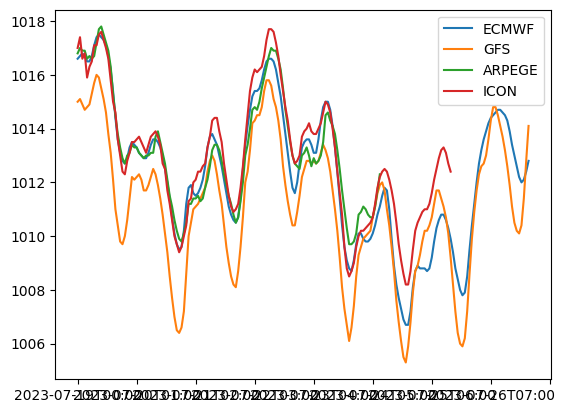

In [10]:
data_presion_df = pd.DataFrame(index=time)

data_presion_df["ECMWF"] = data.loc[nombre_presion+modelo_europeo]["hourly"]

data_presion_df["GFS"] = data.loc[nombre_presion+modelo_gfs]["hourly"]

data_presion_df["AROME"] = data.loc[nombre_presion+modelo_arome]["hourly"]

data_presion_df["ARPEGE"] = data.loc[nombre_presion+modelo_arpege]["hourly"]

data_presion_df["ICON"] = data.loc[nombre_presion+modelo_icon]["hourly"]




data_presion_df.plot()

<Axes: >

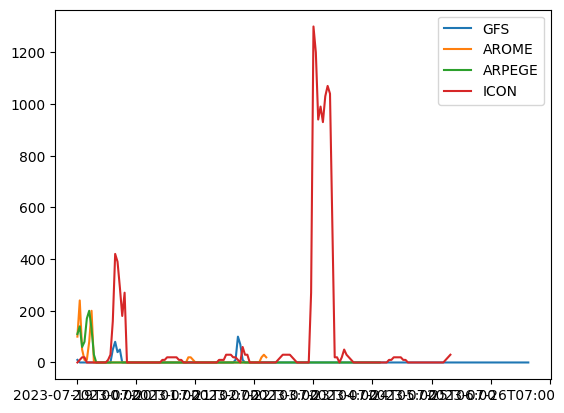

In [11]:
data_cape_df = pd.DataFrame(index=time)

#data_cape_df["ECMWF"] = data.loc[nombre_cape+modelo_europeo]["hourly"]

data_cape_df["GFS"] = data.loc[nombre_cape+modelo_gfs]["hourly"]

data_cape_df["AROME"] = data.loc[nombre_cape+modelo_arome]["hourly"]

data_cape_df["ARPEGE"] = data.loc[nombre_cape+modelo_arpege]["hourly"]

data_cape_df["ICON"] = data.loc[nombre_cape+modelo_icon]["hourly"]




data_cape_df.plot()

<Axes: >

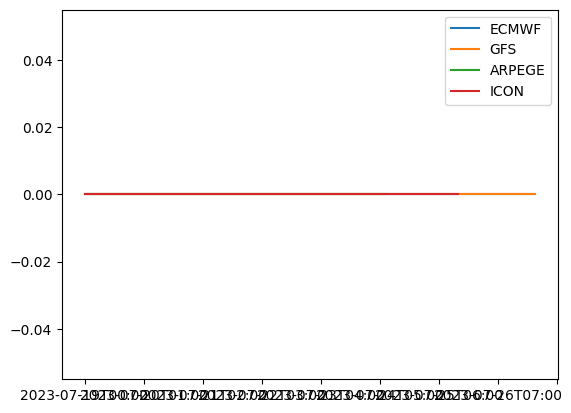

In [12]:
data_preci_df = pd.DataFrame(index=time)

data_preci_df["ECMWF"] = data.loc[nombre_preci+modelo_europeo]["hourly"]

data_preci_df["GFS"] = data.loc[nombre_preci+modelo_gfs]["hourly"]

data_preci_df["AROME"] = data.loc[nombre_preci+modelo_arome]["hourly"]

data_preci_df["ARPEGE"] = data.loc[nombre_preci+modelo_arpege]["hourly"]

data_preci_df["ICON"] = data.loc[nombre_preci+modelo_icon]["hourly"]




data_preci_df.plot()

<Axes: >

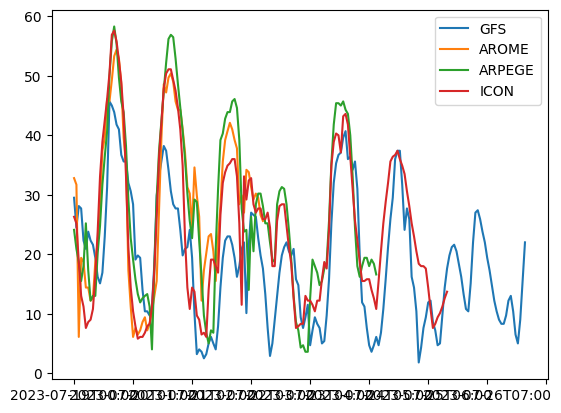

In [13]:
data_rachas_df = pd.DataFrame(index=time)

#data_rachas_df["ECMWF"] = data.loc[nombre_rachas+modelo_europeo]["hourly"]

data_rachas_df["GFS"] = data.loc[nombre_rachas+modelo_gfs]["hourly"]

data_rachas_df["AROME"] = data.loc[nombre_rachas+modelo_arome]["hourly"]

data_rachas_df["ARPEGE"] = data.loc[nombre_rachas+modelo_arpege]["hourly"]

data_rachas_df["ICON"] = data.loc[nombre_rachas+modelo_icon]["hourly"]




data_rachas_df.plot()

<Axes: >

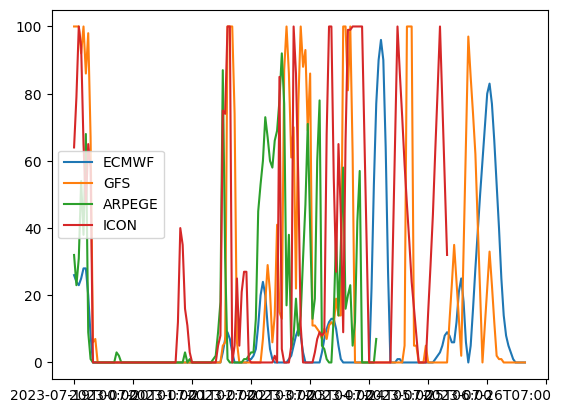

In [14]:
data_nubes_df = pd.DataFrame(index=time)

data_nubes_df["ECMWF"] = data.loc[nombre_nubes+modelo_europeo]["hourly"]

data_nubes_df["GFS"] = data.loc[nombre_nubes+modelo_gfs]["hourly"]

data_nubes_df["AROME"] = data.loc[nombre_nubes+modelo_arome]["hourly"]

data_nubes_df["ARPEGE"] = data.loc[nombre_nubes+modelo_arpege]["hourly"]

data_nubes_df["ICON"] = data.loc[nombre_nubes+modelo_icon]["hourly"]




data_nubes_df.plot()

<Axes: >

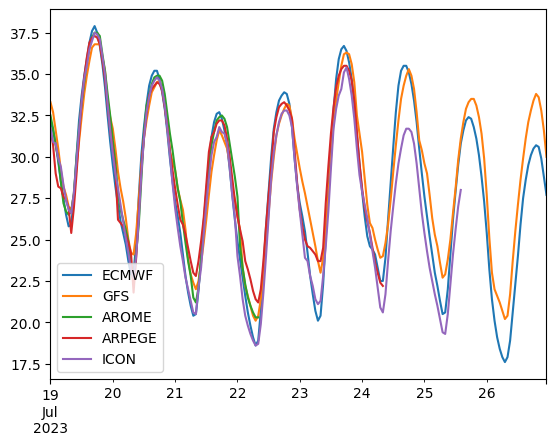

In [15]:
data_temp_df = pd.DataFrame(index=pd.to_datetime(time))

data_temp_df["ECMWF"] = data.loc[nombre_temp+modelo_europeo]["hourly"]

data_temp_df["GFS"] = data.loc[nombre_temp+modelo_gfs]["hourly"]

data_temp_df["AROME"] = data.loc[nombre_temp+modelo_arome]["hourly"]

data_temp_df["ARPEGE"] = data.loc[nombre_temp+modelo_arpege]["hourly"]

data_temp_df["ICON"] = data.loc[nombre_temp+modelo_icon]["hourly"]

data_temp_df.plot()

In [16]:
def all_hours_have_data(group):
    return group.notnull().all()


groups = data_temp_df.groupby(data_temp_df.index.date).apply(all_hours_have_data)


data_temp_max = data_temp_df.groupby(data_temp_df.index.date).max() * groups[groups==True]

data_temp_min = data_temp_df.groupby(data_temp_df.index.date).min() * groups[groups==True]


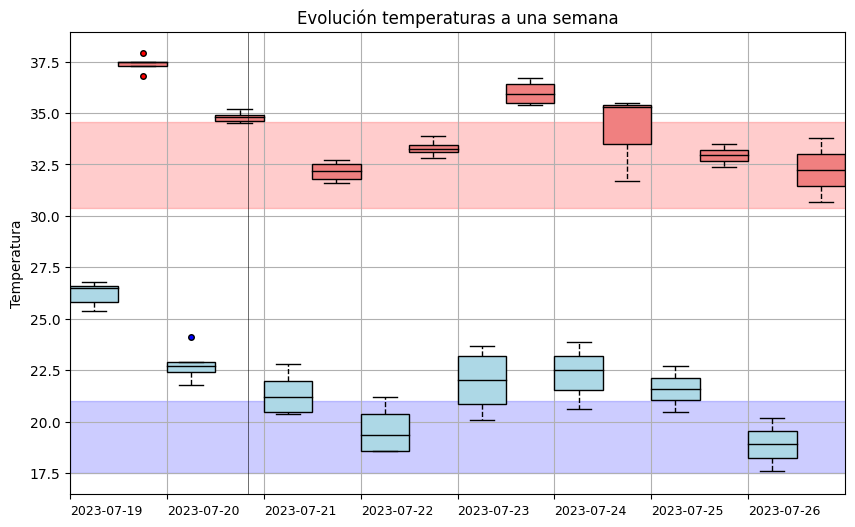

In [39]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

day0 = data_temp_min.iloc[0,:].dropna()
day1 = data_temp_min.iloc[1,:].dropna()
day2 = data_temp_min.iloc[2,:].dropna()
day3 = data_temp_min.iloc[3,:].dropna()
day4 = data_temp_min.iloc[4,:].dropna()
day5 = data_temp_min.iloc[5,:].dropna()
day6 = data_temp_min.iloc[6,:].dropna()
day7 = data_temp_min.iloc[7,:].dropna()

data_plotted = [day0,day1,day2,day3,day4,day5,day6,day7]


boxprops =  dict(linewidth=1, color='black', facecolor='lightblue')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='blue', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

plt.boxplot(data_plotted, positions=[0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25], patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);



day0 = data_temp_max.iloc[0,:].dropna()
day1 = data_temp_max.iloc[1,:].dropna()
day2 = data_temp_max.iloc[2,:].dropna()
day3 = data_temp_max.iloc[3,:].dropna()
day4 = data_temp_max.iloc[4,:].dropna()
day5 = data_temp_max.iloc[5,:].dropna()
day6 = data_temp_max.iloc[6,:].dropna()
day7 = data_temp_max.iloc[7,:].dropna()

data_plotted = [day0,day1,day2,day3,day4,day5,day6,day7]

boxprops =  dict(linewidth=1, color='black', facecolor='lightcoral')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')


plt.boxplot(data_plotted, positions=[0.75,1.75,2.75,3.75,4.75,5.75,6.75,7.75], patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


max_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[0]
max_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[1]

plt.fill_between(data.index,max_usual_temp_upper,max_usual_temp_lower, alpha=0.2, color='red')

min_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[0]
min_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[1]

plt.fill_between(data.index,min_usual_temp_upper,min_usual_temp_lower, alpha=0.2, color='blue')


plt.xlim(0,8)

plt.axvline((datetime.now().hour / 24 + 1),color="black",linewidth=.4)

plt.title("Evolución temperaturas a una semana")
plt.ylabel("Temperatura")

plt.xticks([0,1,2,3,4,5,6,7], data_temp_min.index,ha="center")
plt.xticks(rotation=0, ha='left', fontsize=9)

plt.grid();

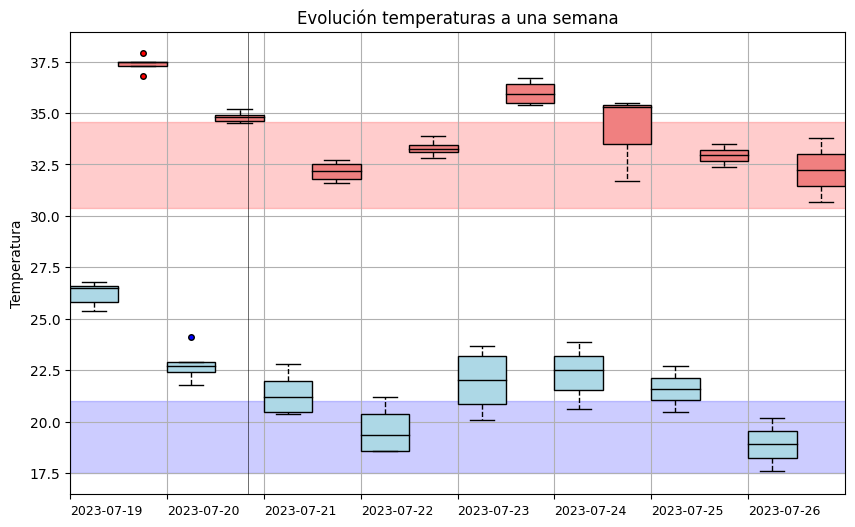

In [57]:
import matplotlib.pyplot as plt


fig,ax = plt.subplots(figsize=(10, 6), dpi=100)



day0 = data_temp_min.iloc[0,:].dropna()
day1 = data_temp_min.iloc[1,:].dropna()
day2 = data_temp_min.iloc[2,:].dropna()
day3 = data_temp_min.iloc[3,:].dropna()
day4 = data_temp_min.iloc[4,:].dropna()
day5 = data_temp_min.iloc[5,:].dropna()
day6 = data_temp_min.iloc[6,:].dropna()
day7 = data_temp_min.iloc[7,:].dropna()

data_plotted = [day0,day1,day2,day3,day4,day5,day6,day7]


boxprops =  dict(linewidth=1, color='black', facecolor='lightblue')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='blue', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

ax.boxplot(data_plotted, positions=[0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25], patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);



day0 = data_temp_max.iloc[0,:].dropna()
day1 = data_temp_max.iloc[1,:].dropna()
day2 = data_temp_max.iloc[2,:].dropna()
day3 = data_temp_max.iloc[3,:].dropna()
day4 = data_temp_max.iloc[4,:].dropna()
day5 = data_temp_max.iloc[5,:].dropna()
day6 = data_temp_max.iloc[6,:].dropna()
day7 = data_temp_max.iloc[7,:].dropna()

data_plotted = [day0,day1,day2,day3,day4,day5,day6,day7]

boxprops =  dict(linewidth=1, color='black', facecolor='lightcoral')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')


ax.boxplot(data_plotted, positions=[0.75,1.75,2.75,3.75,4.75,5.75,6.75,7.75], patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


max_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[0]
max_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[1]

ax.fill_between(data.index,max_usual_temp_upper,max_usual_temp_lower, alpha=0.2, color='red')

min_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[0]
min_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[1]

ax.fill_between(data.index,min_usual_temp_upper,min_usual_temp_lower, alpha=0.2, color='blue')



ax.set_xlim(0,8)

ax.axvline((datetime.now().hour / 24 + 1),color="black",linewidth=.4)


ax.set_title("Evolución temperaturas a una semana")
ax.set_ylabel("Temperatura")


ax.set_xticks([0,1,2,3,4,5,6,7], data_temp_min.index,ha="center")
ax.set_xticklabels(labels=data_temp_min.index, rotation=0, ha='left', fontsize=9)



ax.grid();



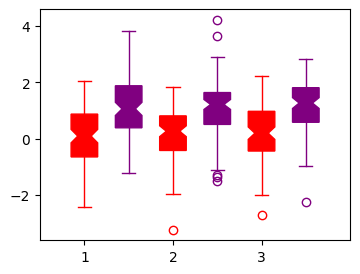

In [55]:
import matplotlib.pyplot as plt
import numpy as np
data = np.random.normal(0.1, size=(100,6))
data[76:79,:] = np.ones((3,6))+0.2

plt.figure(figsize=(4,3))
# option 1, specify props dictionaries
c = "red"
plt.boxplot(data[:,:3], positions=[1,2,3], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )


# option 2, set all colors individually
c2 = "purple"
box1 = plt.boxplot(data[:,::-2]+1, positions=[1.5,2.5,3.5], notch=True, patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c2)
plt.setp(box1["boxes"], facecolor=c2)
plt.setp(box1["fliers"], markeredgecolor=c2)
            

plt.xlim(0.5,4)
plt.xticks([1,2,3], [1,2,3])
plt.show()

In [58]:
pd.DataFrame(data[:,:3])

,0,1,2
0,-0.161153,1.203730,1.685119
1,1.537597,0.720846,1.346423
2,0.511909,1.014079,0.408457
3,-0.415010,-0.294694,-1.973579
4,0.320616,0.219109,0.693791
...,...,...,...
95,-0.045172,1.262888,0.076400
96,0.025356,-0.956940,0.321915
97,-1.178762,0.606124,-1.832675
98,0.032028,-0.936454,-0.702511
